# 1.3.4: World Population: Adding Flexibility

<br>

---

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

## Streamlining our Code

We now have two ways (linear and proportional) to model world population, and two entirely separate simulations.  This is inefficient and inconvenient.  This notebook shows how we can clean this up and easily plug a new model into our simulation.

### Organizing our parameters

<br>

The first thing we'll do is pull our system parameters and independent variables, which generally do not change during a simulation, into a single *system object*.  For example, in the bikeshare model, system parameters included the number of locations, total number of bikes, and arrival rates at each location.  In our models, system parameters include the the initial population as well as and the start and end times.  The independent variables are the annual growth (linear model) and the growth rate alpha (proportional model).

<br>

We'll start by uploading our data and organizing it, just as we did in the last notebook.

In [ ]:
# @title
# Import Pandas and give it the shorthand name "pd"
import pandas as pd

# Define the file we want to import
address = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/'
file_loc = 'Images_and_Data/Data/World_pop_data.xlsx'

# Import the world population data
data = pd.read_excel(address + file_loc, header=0,index_col=0)
census = data.US_census
un = data.UN

# Create model parameters
t_0 = census.index[0]
t_end = census.index[-1]
p_0 = census[t_0]

# Create independent variables for linear model
elapsed_time = t_end - t_0
total_growth = census[t_end] - census[t_0]
annual_growth = total_growth/ elapsed_time

# Create independent variables for proportional model
alpha = (25.0-7.7)/1000

Now we'll *pack* these parameters into a single `object`.  We'll put the them into a standard Python `dictionary` object here, because it stores paired keys and values:

In [ ]:
system = dict(t_0=t_0,  t_end=t_end,
               p_0=p_0, annual_growth=annual_growth, alpha = alpha)
system

{'t_0': 1950,
 't_end': 2016,
 'p_0': 2.557628654,
 'annual_growth': 0.07224800083333333,
 'alpha': 0.0173}

You might ask: "Isn't it obvious that t_0 = t_0?"  But remember, `=` does not state an equality.  It is an *assignment* operator.  The `t_0` on the right is the global variable t_0 (which here is equal to 1950).  `t_0 = t_0` is assigning this value (1950) to the label inside the dictionary called system.  Now both the global variable `t_0` and the dictionary item `system[t_0]` are equal to 1950.

<br>

The advantage of packing these variables together is that it allows us to import them into a function as a group rather than 1 at a time.  It's just a matter of convenience.

### Organizing our simulation code

<br>

The next 'streamlining' step we'll take is to wrap the code from the previous chapter in a function:

In [ ]:
def run_simulation_lin(system):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']

    for t in range(system['t_0'], system['t_end']):
        results[t+1] = results[t] + system['annual_growth']

    return results

`run_simulation_lin` takes a system object as an argument.  Notice how it uses brackets (with quote marks) to pull the contents of `system` out when it needs them.  

<br>

This function simulates population growth over time and returns the results in a `Series`.  Here's how we call the new function.

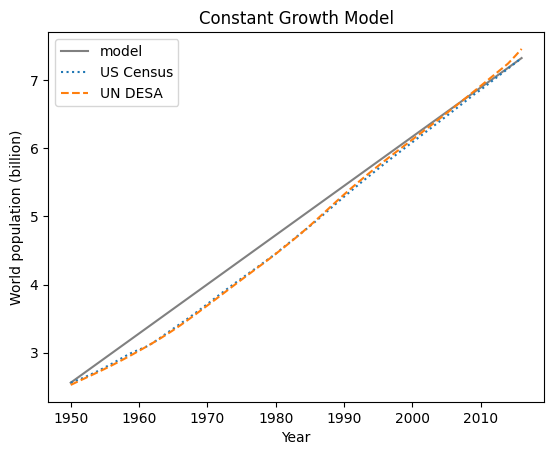

In [ ]:
results_lin = run_simulation_lin(system)
results_lin.plot(label='model', color='gray',
              title='Constant Growth Model',legend=True)
census.plot(style=':', label='US Census',legend=True)
un.plot(style='--', label='UN DESA', xlabel='Year',
             ylabel='World population (billion)',
           legend=True);

### Adding flexibility to our simulation code

Finally, we want to revise `run_simulation` so that it can handle different types of models.  Look at `run_simulation_lin`: the only line that makes this a linear simulation is line 6 (`results[t+1] = ....`).  If we wrote `run_simulation_prop`, we'd only have to change this one line.  

<br>

This is an indicator that we should consider an approach that might be more efficient: if your code repeats itself a lot, updating and changing that code becomes laborious and bug-filled.

<br>

Rather than repeat identical code, we can separate the things that
change from the things that don't. What we need are two functions that *only* calculate the annual growth.  The functions should pull in the current population as an argument, and return the population growth for that time step:

In [ ]:
def change_func_lin(t, pop, system):
    growth = system['annual_growth']
    return growth

def change_func_prop(t, pop, system):
    growth = system['alpha'] * pop
    return growth

Both functions take the same arguments, and return the population growth for the current year: the fact that these functions pull in and spit out the same values is important, because we want to use them interchangeably.

<br>

Notice that neither of these functions uses the argument $t$.  We've added it in here, though, because some other change function might use $t$ (as in the exercises below), and the format of all the change functions must be the same.

<br>

Now we can write a function that runs with any `change_func` that we might want to define:

In [ ]:
def run_simulation(system, change_func):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']

    for t in range(system['t_0'], system['t_end']):
        growth = change_func(t, results[t], system)
        results[t+1] = results[t] + growth

    return results

This function demonstrates a feature we have not seen before: it takes a
function as a parameter! When we call `run_simulation`, the second
parameter is a function, like `change_func_prop`, that computes the
population for the next year.  Here's how we call it:

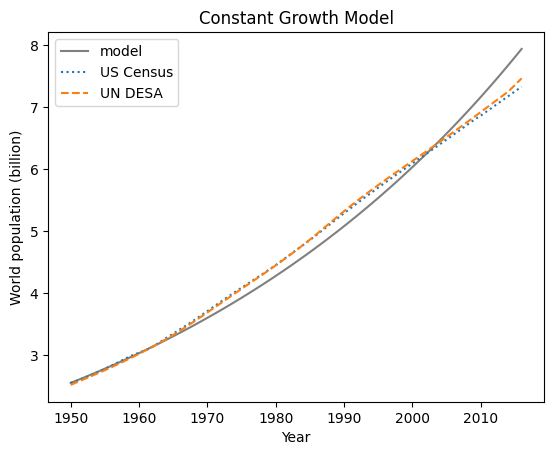

In [ ]:
# Run the simulation
results_prop = run_simulation(system, change_func_prop)

# Check our results
results_prop.plot(label='model', color='gray',
              title='Constant Growth Model',legend=True)
census.plot(style=':', label='US Census',legend=True)
un.plot(style='--', label='UN DESA', xlabel='Year',
             ylabel='World population (billion)',
           legend=True);

Passing a function as an argument is the same as passing any other
value. `change_func_prop` is
assigned to `change_func` inside the function. Each time through the loop, `run_simulation` calls `change_func_prop` to compute net growth, and uses it to compute the population during the next year.

It might not be obvious that using functions and a system object is a
big improvement, and for a simple model that we run only once, maybe
it's not. But as we work with more complex models, and when we run many simulations with different parameters, we'll see that this way of organizing the code makes a big difference.

<br>

---

## Exercises

---

<br>

🟨 🟨


### Exercise 1

Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after a given year.

<br>

Write an updated change function that takes `t`, `pop`, and `system` as parameters.  This will require a couple steps:

<br>

1. Define three new parameters: the growth rate before the
change (`alpha1`), the growth rate after 1980 (`alpha2`), and the year of the change (`t_change`). The function should use `t` to determine which growth rate to use.


2. Add the new parameters to a system object

3. Write a new `change_func_prop_change()` that uses an `if` clause to determine the growth for that year.

4. Test the change function by itself, and then test it with `run_simulation

In [ ]:
# Define alpha1, alpha2, and t_change




In [ ]:
# Create a system object that includes these new parameters

In [ ]:
# Create new change function using alpha1 and alpha2
# It should have the same arguments as those above, and should return "growth"
# You'll need to use an "if" clause
def change_func_prop_change(t, pop, system):


In [ ]:
# Test the new change function by calling it with an easy to calculate
# population (like 10) and changing 't' to make sure you get the correct
# answer
growth = change_func_prop_change(1950,10,system)
print(growth)


In [ ]:
# Run using run_simulation and plot results


---

<br>

🟨 🟨

### Exercise 2

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the three new parameters to fit the data as well as you can.  Answer two questions:

<br>

* What approximate values work best for the data fit?

<br>

* Assuming that this model fits the data better than the constant alpha model, explain why this model might not be the best model conceptually.  In what way(s) does it not make intuitive sense as a model?

✅ ✅ Put your answers here